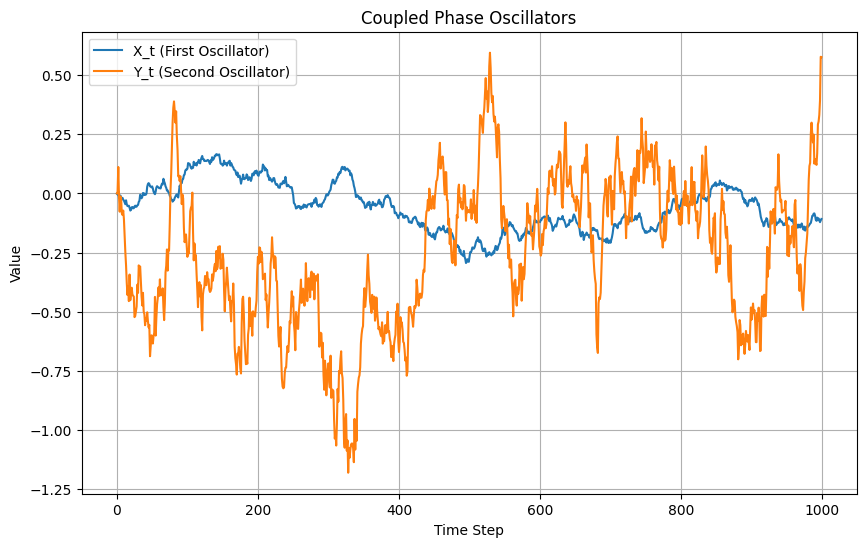

In [52]:
import torch
import math
def simulate_coupled_phase_oscillators(
    X0, Y0, theta, dt, num_steps, sigma1, sigma2, device="cpu"
):
    """
    Simulates the coupled phase oscillators using Euler-Maruyama method.

    Args:
        X0 (float): Initial condition for X_t.
        Y0 (float): Initial condition for Y_t.
        theta (float): Coupling parameter (0 to 1).
        dt (float): Time step size.
        num_steps (int): Number of time steps to simulate.
        sigma1 (float): Diffusion coefficient for X_t.
        sigma2 (float): Diffusion coefficient for Y_t.
        device (str): Device for computation ("cpu" or "cuda").

    Returns:
        torch.Tensor: Simulated values of X_t and Y_t over time (shape: [num_steps, 2]).
    """
    # Initialize tensors for the results
    X = torch.zeros(num_steps, device=device)
    Y = torch.zeros(num_steps, device=device)
    X[0], Y[0] = X0, Y0

    # Wiener processes
    W1 = math.sqrt(dt) * torch.randn(num_steps, device=device)
    W2 = math.sqrt(dt) * torch.randn(num_steps, device=device)

    for t in range(1, num_steps):
        # Drift and diffusion for X_t
        drift_X = -X[t-1]**3
        diffusion_X = 0.1 * torch.sqrt(1 + X[t-1]**2)

        # Drift and diffusion for Y_t
        drift_Y = theta * torch.sin(X[t-1]) - 0.5 * Y[t - 1]
        diffusion_Y = math.sqrt(theta) * torch.exp(-X[t-1]**2)

        # Euler-Maruyama update
        X[t] = X[t - 1] + drift_X * dt + diffusion_X * W1[t]
        Y[t] = Y[t - 1] + drift_Y * dt + diffusion_Y * W2[t]

    return torch.stack([X, Y], dim=1)


# Simulation parameters
X0 = 0.0  # Initial value of X_t
Y0 = 0.0  # Initial value of Y_t
theta = 0.5  # Coupling parameter
dt = 0.01  # Time step size
num_steps = 1000  # Number of time steps
sigma1 = 0.1  # Diffusion coefficient for X_t
sigma2 = 0.1  # Diffusion coefficient for Y_t

# Simulate on CPU or GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
trajectory = simulate_coupled_phase_oscillators(X0, Y0, theta, dt, num_steps, sigma1, sigma2, device)

# Extract results
X_traj, Y_traj = trajectory[:, 0].cpu().numpy(), trajectory[:, 1].cpu().numpy()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X_traj, label="X_t (First Oscillator)")
plt.plot(Y_traj, label="Y_t (Second Oscillator)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Coupled Phase Oscillators")
plt.legend()
plt.grid()
plt.show()

In [53]:
def sample(n, theta=0, start=0, stop=1, dt=0.005, thin=0):
    l = math.ceil((stop - start) / dt) + 1

    X = torch.zeros(l, n, device=device)
    Y = torch.zeros(l, n, device=device)
    X[0], Y[0] = 0, 0

    # Wiener processes for the batch
    W1 = math.sqrt(dt) * torch.randn(l, n, device=device)
    W2 = math.sqrt(dt) * torch.randn(l, n, device=device)

    for t in range(1, l):
        # Drift and diffusion for X_t
        drift_X = -X[t - 1] ** 3
        diffusion_X = 0.1 * torch.sqrt(1 + X[t - 1] ** 2)

        # Drift and diffusion for Y_t
        drift_Y = theta * torch.sin(X[t - 1]) - Y[t - 1]
        diffusion_Y = 0.1 * math.sqrt(theta) * torch.exp(-X[t - 1] ** 2)

        # Euler-Maruyama update
        X[t] = X[t - 1] + drift_X * dt + diffusion_X * W1[t]
        Y[t] = Y[t - 1] + drift_Y * dt + diffusion_Y * W2[t]
        
    return X.view(n, l, -1)[:,range(0, l, 2**thin)], Y.view(n, l, -1)[:,range(0, l, 2**thin)]

In [56]:
x, y = sample(10, theta=0.5, thin=0)

In [39]:
y.shape

torch.Size([10, 101, 1])

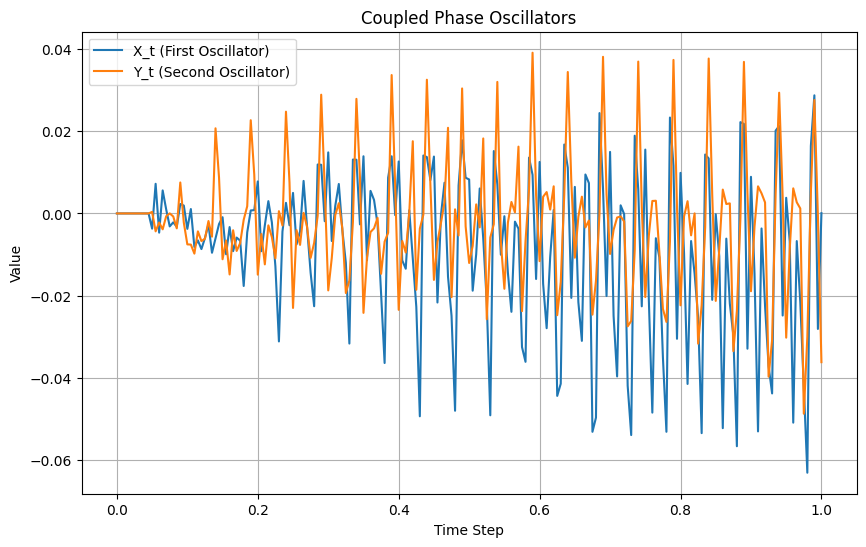

In [57]:
import matplotlib.pyplot as plt
tt = torch.linspace(0, 1, 201).numpy()
x_traj = x[0].view(-1).cpu().numpy()
y_traj = y[0].view(-1).cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(tt, x_traj, label="X_t (First Oscillator)")
plt.plot(tt, y_traj, label="Y_t (Second Oscillator)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Coupled Phase Oscillators")
plt.legend()
plt.grid()
plt.show()

In [165]:
import torch
import math

def NonLinearSDE(
    n, theta=0, dt=0.005, start=0, stop=1, thin=0, device=torch.device('cuda:0'), dtype=torch.float64
):
    # Initialize tensors for the results
    num_steps = math.ceil((stop - start) / dt)
    X = torch.zeros(n, num_steps + 1, device=device, dtype=dtype)
    Y = torch.zeros(n, num_steps + 1, device=device, dtype=dtype)
    X[0], Y[0] = 0, 0

    # Wiener processes for the batch
    W1 = math.sqrt(dt) * torch.randn(n, num_steps, device=device, dtype=dtype)
    W2 = math.sqrt(dt) * torch.randn(n, num_steps, device=device, dtype=dtype)

    for t in range(1, num_steps + 1):
        # Drift and diffusion for X_t
        drift_X = -X[:,t - 1]**3
        diffusion_X = torch.sqrt(1 + X[:,t - 1] ** 2)

        # Drift and diffusion for Y_t
        drift_Y = theta * torch.sin(X[:,t - 1]) - Y[:,t - 1]
        diffusion_Y = math.sqrt(theta) * torch.exp(-X[:,t - 1] ** 2) + 0.5

        # Euler-Maruyama update
        X[:,t] = X[:,t - 1] + drift_X * dt + diffusion_X * W1[:,t - 1]
        Y[:,t] = Y[:,t - 1] + drift_Y * dt + diffusion_Y * W2[:,t - 1]

    return X.view(n, num_steps + 1, 1)[:,range(0, num_steps + 1, 2**thin),:], Y.view(n, num_steps + 1, -1)[:,range(0, num_steps + 1, 2**thin),:]

In [272]:
def thin(x, short_min=0.5, short_max=1):
    l = x.shape[1]
    n = x.shape[0]
    device = x.device
    short_min = math.ceil(l * short_min)
    short_max = math.ceil((l - 1) * short_max)
    thin_int = torch.randint(short_min, short_max, (n,), device=device)
    for i in range(x.shape[0]):
        ii = torch.rand(l, device=device).argsort(dim=0)[:thin_int[i]].sort(dim=0).values
        x[i, :thin_int[i], :] = x[i, ii, :]
        x[i, :thin_int[i], :] = x[i, ii, :]
        x[i, thin_int[i]:l, :] = x[i, thin_int[i], :]
    return x

In [234]:
def thin_seq(x, id):
    l = x.shape[1]
    for i in range(x.shape[0]):
        ii = id[i]
        x[i, ii:l, :] = x[i, ii, :]
    return x    

In [280]:

tt, ii = thin(X)

In [282]:
ii

tensor([  0,   4,   8,  10,  14,  15,  16,  17,  19,  21,  22,  24,  25,  26,
         27,  34,  35,  37,  38,  39,  40,  41,  42,  45,  46,  47,  50,  51,
         52,  53,  54,  57,  59,  63,  64,  65,  67,  69,  70,  72,  74,  75,
         76,  79,  81,  82,  83,  84,  85,  86,  87,  91,  92,  97,  98, 100],
       device='cuda:0')

In [166]:
X, Y = NonLinearSDE(10, theta=1, dt=0.005, thin=1, device=device)
X

tensor([[[ 0.0000],
         [ 0.0332],
         [ 0.0656],
         ...,
         [ 0.0276],
         [ 0.0390],
         [-0.0459]],

        [[ 0.0000],
         [-0.1093],
         [-0.1183],
         ...,
         [-1.0825],
         [-1.1085],
         [-1.0558]],

        [[ 0.0000],
         [-0.1314],
         [-0.2048],
         ...,
         [-0.4771],
         [-0.7521],
         [-0.9110]],

        ...,

        [[ 0.0000],
         [ 0.0679],
         [ 0.1014],
         ...,
         [-1.2905],
         [-1.2290],
         [-1.1078]],

        [[ 0.0000],
         [ 0.1308],
         [ 0.2675],
         ...,
         [-1.0050],
         [-0.9282],
         [-1.1750]],

        [[ 0.0000],
         [ 0.1063],
         [ 0.1378],
         ...,
         [ 0.3240],
         [ 0.3352],
         [ 0.3706]]], device='cuda:0', dtype=torch.float64)